In [1]:
import os
import shutil
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import timm

import matplotlib.pyplot as plt # For data viz
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

C:\Users\Muhammad.Taha2\.conda\envs\ibex-updated\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


System Version: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
PyTorch version 2.1.0
Torchvision version 0.15.2a0
Numpy version 1.25.2
Pandas version 2.0.3


In [3]:
# Define the paths to the source directory and destination directories
source_dir = 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\train'
train_dir = 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Train'
test_dir = 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Test'
validation_dir = 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Validate'

data = pd.read_csv(os.path.join(source_dir,"_classes.csv"))

In [4]:
print(data.shape)
data.head(5)

(2349, 8)


,filename,Unlabeled,age related macular degeneration,cataract,diabetes,glaucoma,hypertension,normal
0,image190_png.rf.d862e83fc7aa54f471de7c5a3c4882...,0,0,0,0,1,0,0
1,3416_left_jpg.rf.d907909022677bcd8843b15fa4fb8...,0,0,0,0,0,0,1
2,_12_7315004_jpg.rf.d917e101f464914706d8c39f100...,0,0,0,0,0,1,0
3,1869_left_jpg.rf.da408b295014fa98a8f90297afafb...,0,1,0,0,0,0,0
4,1043_right_jpg.rf.d9adccaa1c2e7dafa0c648b83b9b...,0,1,0,0,0,0,0


In [5]:
indexes = data.loc[data[' Unlabeled'] == 1].index
data = data.drop(indexes)
data = data.reset_index(drop = True)
data.drop([' Unlabeled'], axis=1, inplace=True)

In [6]:
print(data.shape)
data.head(5)

(2335, 7)


,filename,age related macular degeneration,cataract,diabetes,glaucoma,hypertension,normal
0,image190_png.rf.d862e83fc7aa54f471de7c5a3c4882...,0,0,0,1,0,0
1,3416_left_jpg.rf.d907909022677bcd8843b15fa4fb8...,0,0,0,0,0,1
2,_12_7315004_jpg.rf.d917e101f464914706d8c39f100...,0,0,0,0,1,0
3,1869_left_jpg.rf.da408b295014fa98a8f90297afafb...,1,0,0,0,0,0
4,1043_right_jpg.rf.d9adccaa1c2e7dafa0c648b83b9b...,1,0,0,0,0,0


In [7]:
# Function to get the column name where the value is 1
def get_category(row):
    categories = row.index[row == 1].tolist()
    return categories[0] if categories else 'unknown'

# Apply the function to each row
data['Label'] = data.apply(get_category, axis=1)

data.head(5)

,filename,age related macular degeneration,cataract,diabetes,glaucoma,hypertension,normal,Label
0,image190_png.rf.d862e83fc7aa54f471de7c5a3c4882...,0,0,0,1,0,0,glaucoma
1,3416_left_jpg.rf.d907909022677bcd8843b15fa4fb8...,0,0,0,0,0,1,normal
2,_12_7315004_jpg.rf.d917e101f464914706d8c39f100...,0,0,0,0,1,0,hypertension
3,1869_left_jpg.rf.da408b295014fa98a8f90297afafb...,1,0,0,0,0,0,age related macular degeneration
4,1043_right_jpg.rf.d9adccaa1c2e7dafa0c648b83b9b...,1,0,0,0,0,0,age related macular degeneration


In [8]:
# Stratified split the data into training, test, and validation sets
train_data, temp_data = train_test_split(data, test_size=0.4, stratify=data['Label'], random_state=42)
test_data, validation_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['Label'], random_state=42)


# Create subfolders for each label in the destination directories
for label in data['Label'].unique():
    label_train_dir = os.path.join(train_dir, label)
    label_test_dir = os.path.join(test_dir, label)
    label_validation_dir = os.path.join(validation_dir, label)

    os.makedirs(label_train_dir, exist_ok=True)
    os.makedirs(label_test_dir, exist_ok=True)
    os.makedirs(label_validation_dir, exist_ok=True)

# Move the images to the corresponding subfolders
for index, row in train_data.iterrows():
    src_path = os.path.join(source_dir, row['filename'])
    dest_path = os.path.join(train_dir, row['Label'], row['filename'])
    shutil.copy(src_path, dest_path)

for index, row in test_data.iterrows():
    src_path = os.path.join(source_dir, row['filename'])
    dest_path = os.path.join(test_dir, row['Label'], row['filename'])
    shutil.copy(src_path, dest_path)

for index, row in validation_data.iterrows():
    src_path = os.path.join(source_dir, row['filename'])
    dest_path = os.path.join(validation_dir, row['Label'], row['filename'])
    shutil.copy(src_path, dest_path)


# Step 1. Pytorch Dataset (and Dataloader)

In [9]:
class ImagesDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

## Create Test Dataset

In [11]:
dataset = ImagesDataset(
    data_dir= 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Train'
)

In [12]:
len(dataset)

1401

5


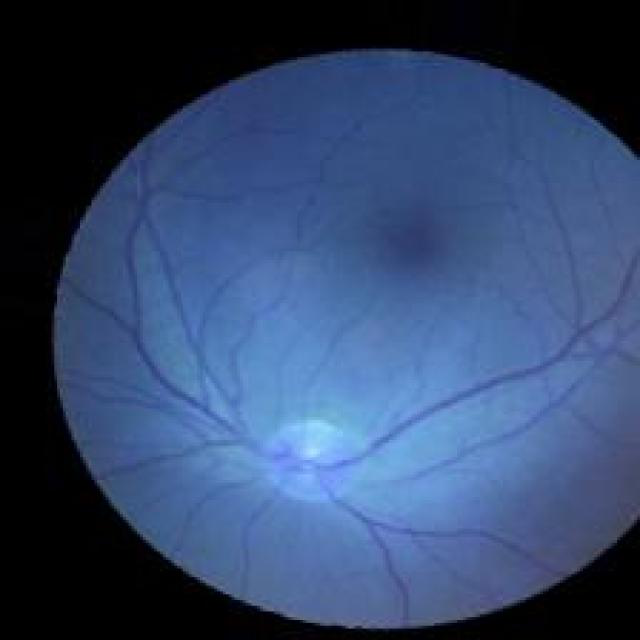

In [13]:
image, label = dataset[1400]
print(label)
image

In [14]:
# Get a dictionary associating target values with folder names
data_dir= 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: ' age related macular degeneration', 1: ' cataract', 2: ' diabetes', 3: ' glaucoma', 4: ' hypertension', 5: ' normal'}


In [15]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir= 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Train'
dataset = ImagesDataset(data_dir, transform)

In [16]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [17]:
# iterate over dataset
for image, label in dataset:
    break

## Dataloaders

In [18]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [19]:
for images, labels in dataloader:
    break

In [20]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [21]:
labels

tensor([4, 3, 0, 4, 1, 0, 4, 0, 0, 4, 3, 2, 1, 1, 5, 1, 2, 1, 5, 4, 0, 2, 5, 5,
        1, 5, 3, 3, 5, 4, 0, 2])

# Step 2. Pytorch Model

In [22]:
class SimpleImageClassifer(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleImageClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),  # Dropout layer added here
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output
    

In [23]:
model = SimpleImageClassifer(num_classes=6)
#print(str(model)[:500])

In [24]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 6])

# Step 3. The training loop

In [25]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 6]) torch.Size([32])


## Setup Datasets

In [27]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Train'
valid_folder = 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Test'
test_folder = 'C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Validate'


train_dataset = ImagesDataset(train_folder, transform=transform)
val_dataset = ImagesDataset(valid_folder, transform=transform)
test_dataset = ImagesDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Simple Training Loop

In [28]:
from ipywidgets import FloatProgress

In [30]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []
patience = 2  # Number of epochs to wait before stopping training when validation loss increases

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleImageClassifer(num_classes=6)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Added weight decay for regularization

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
    
    # Check if we should stop training
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print("Early stopping due to increase in validation loss")
        break


Training loop:   0%|          | 0/44 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.2781678647504884, Validation loss: 1.2165414495692775


Training loop:   0%|          | 0/44 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 1.0301188715945644, Validation loss: 1.1343815533456252


Training loop:   0%|          | 0/44 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.8977219394323742, Validation loss: 1.2119670442646524


Training loop:   0%|          | 0/44 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.8278704558330974, Validation loss: 1.1441542224148866
Early stopping due to increase in validation loss


# Visualize Losses

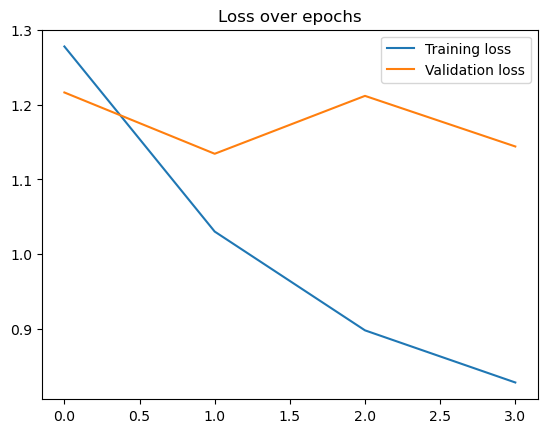

In [31]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Evaluating the Results

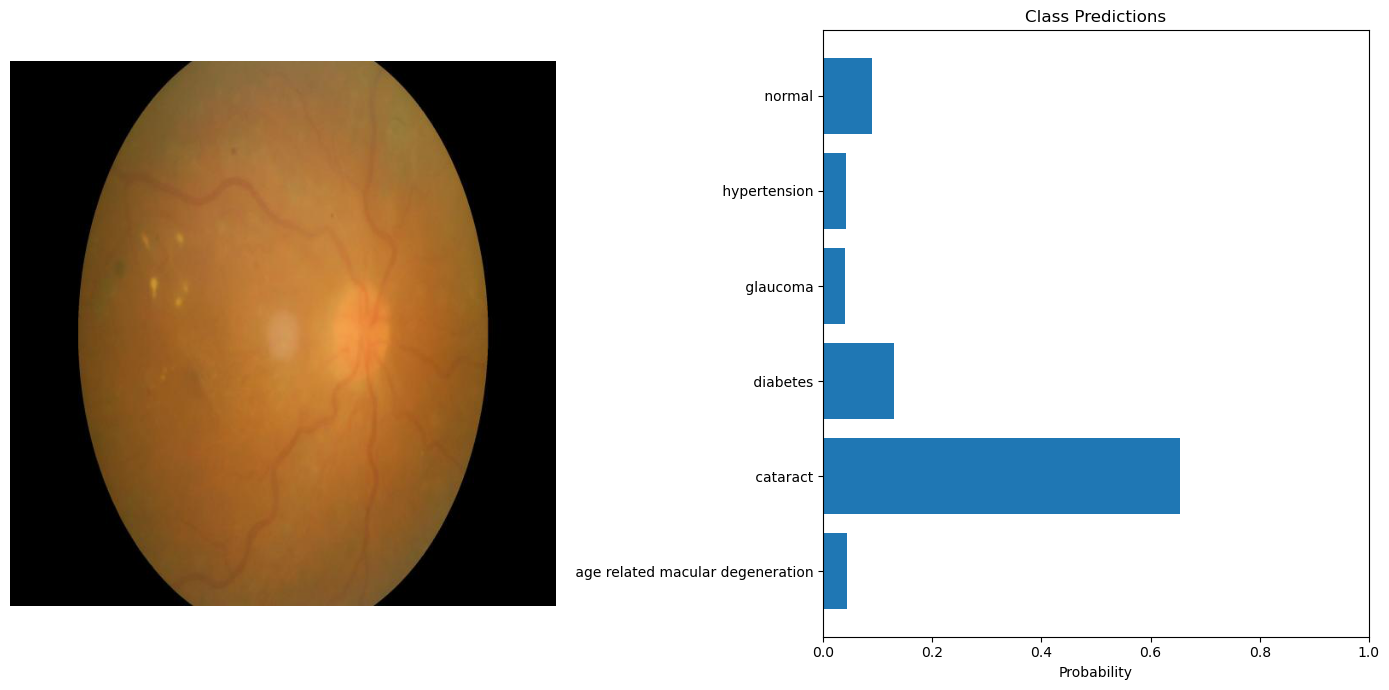

In [32]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Test\\ diabetes\\568_right_jpg.rf.d8ebf9d8c79d23c651f5182c902ec4e6.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

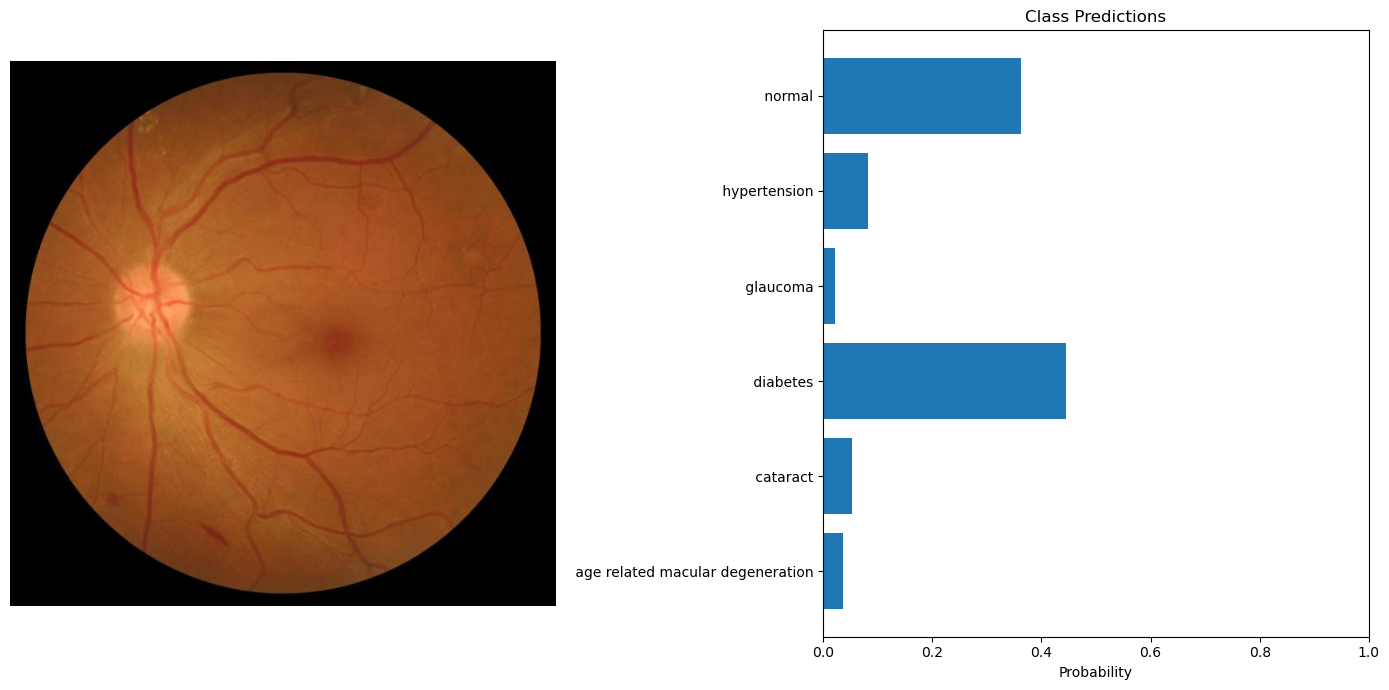

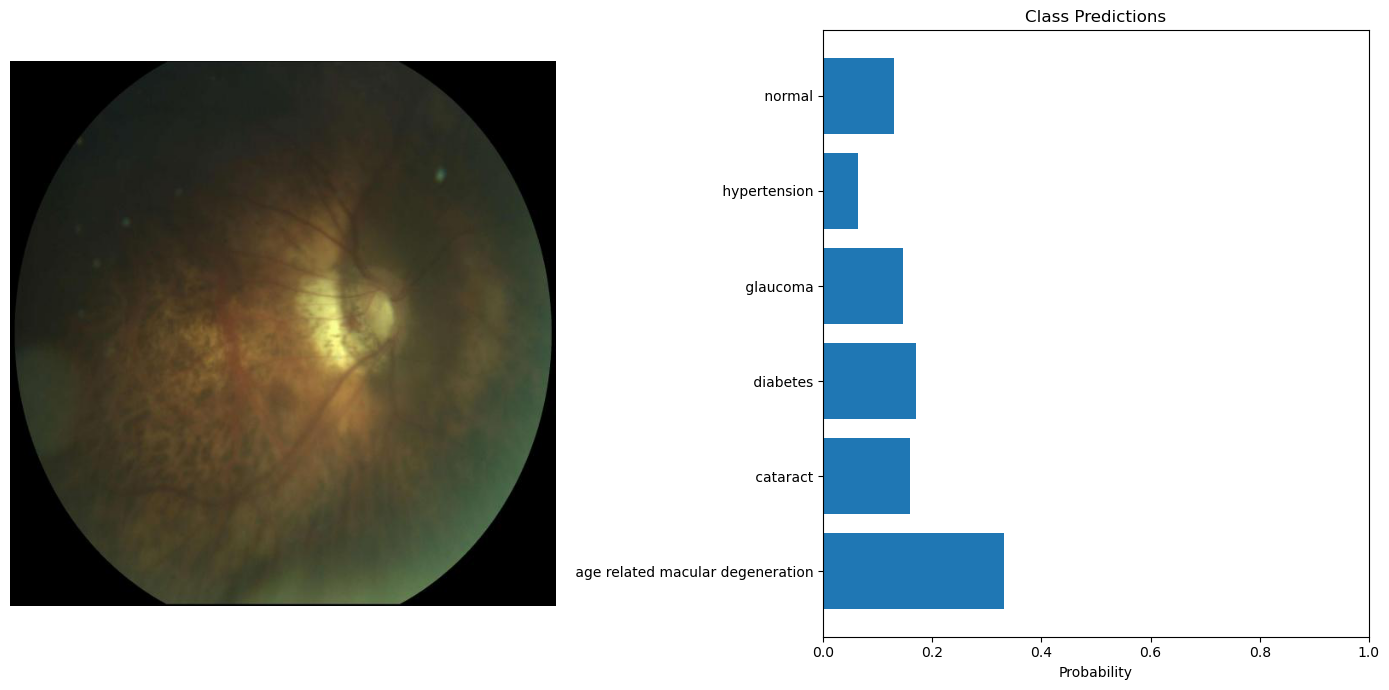

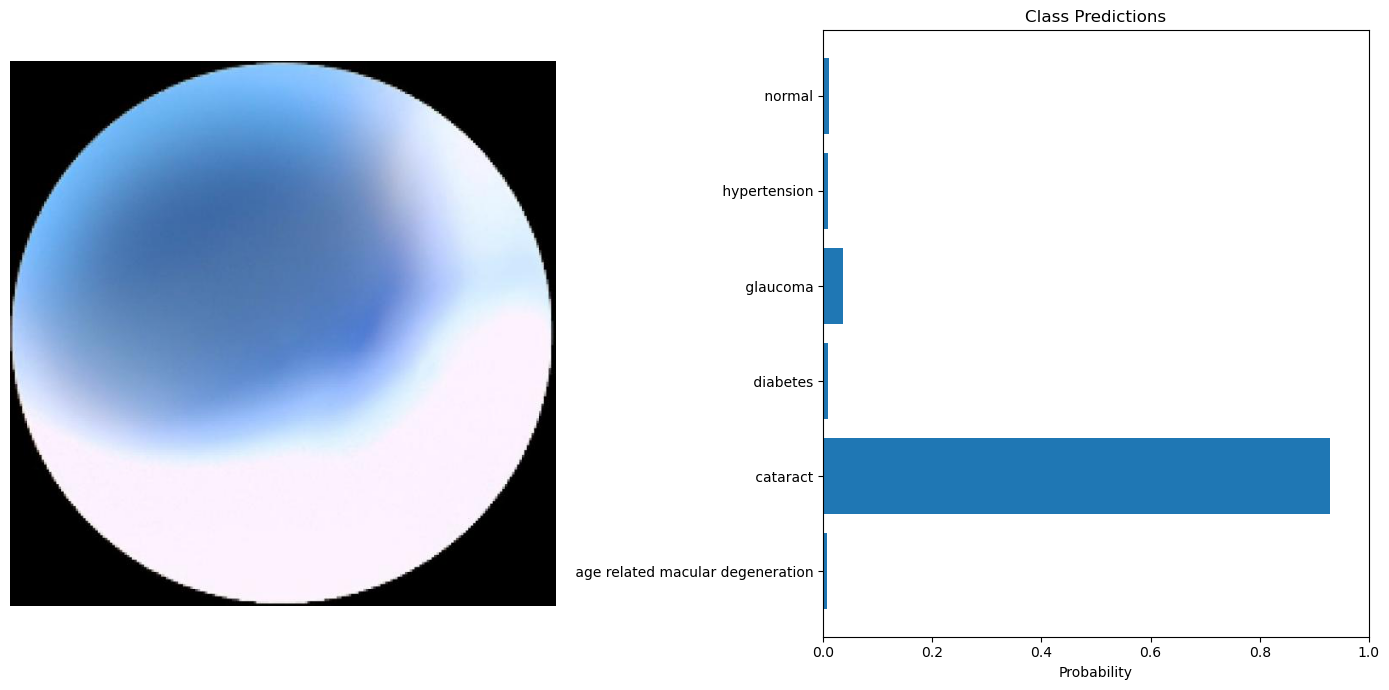

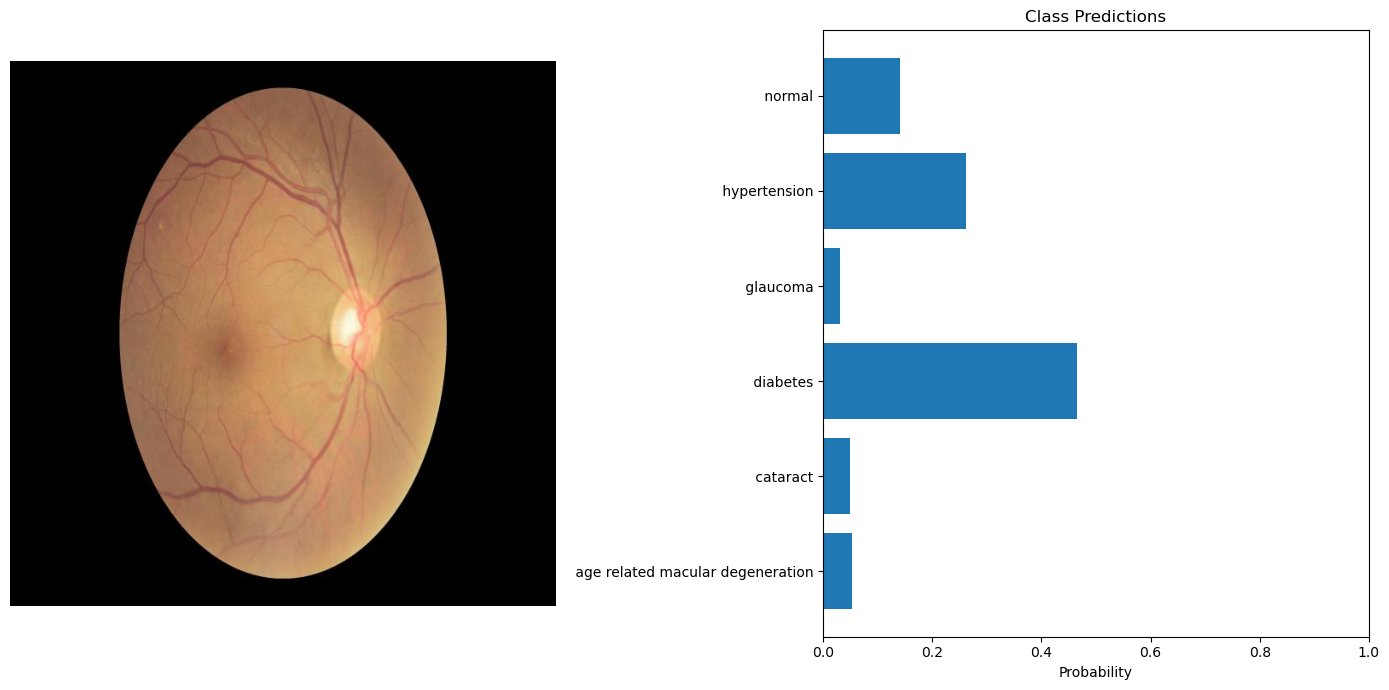

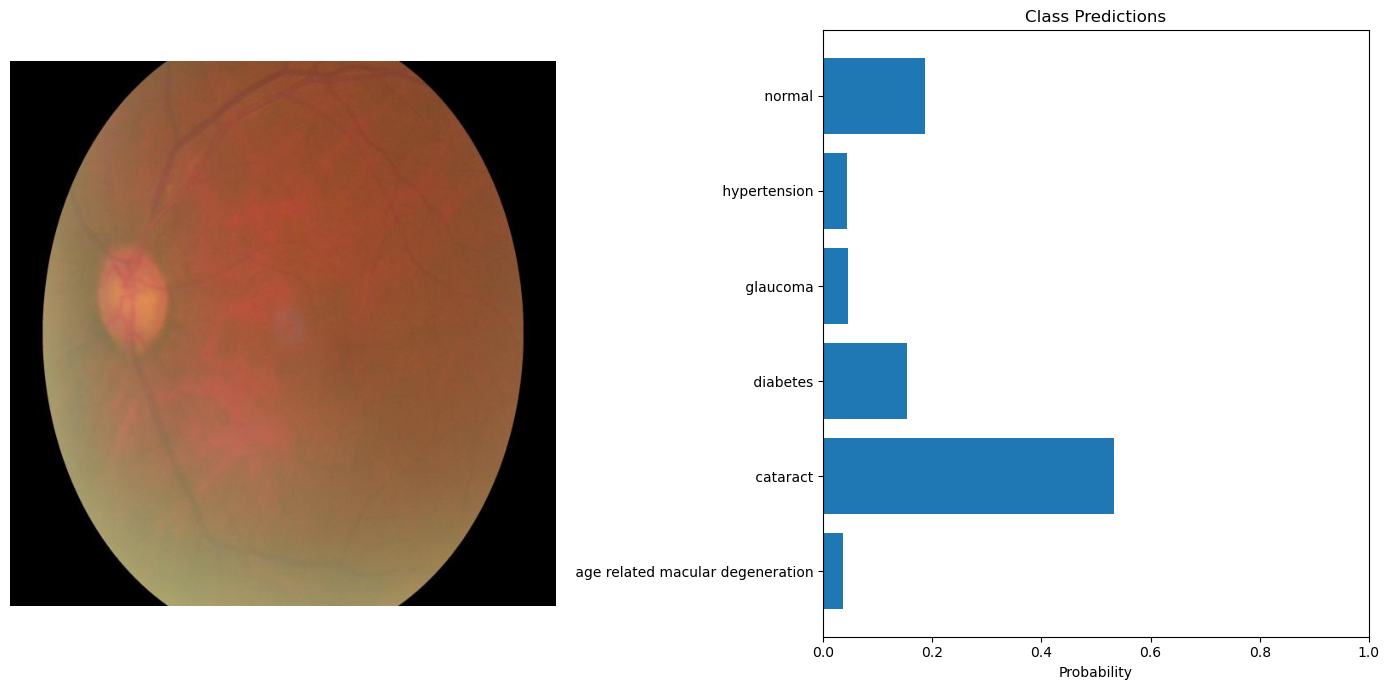

In [33]:
from glob import glob
test_images = glob('C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Test\\*\\*')
test_examples = np.random.choice(test_images, 5)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

## Checking Performance on Validation data

In [34]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming you have a DataLoader for the validation set named 'val_loader'
# and you have the ground truth labels in 'val_labels'

# Set the model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get predicted labels
        predictions = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Store predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
precision = precision_score(all_true_labels, all_predictions, average='weighted')
recall = recall_score(all_true_labels, all_predictions, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.5546
F1 Score: 0.5471
Precision: 0.6134
Recall: 0.5546


In [38]:
import joblib
joblib.dump(model, 'Image_Classification_Model.pkl')

['Image_Classification_Model.pkl']

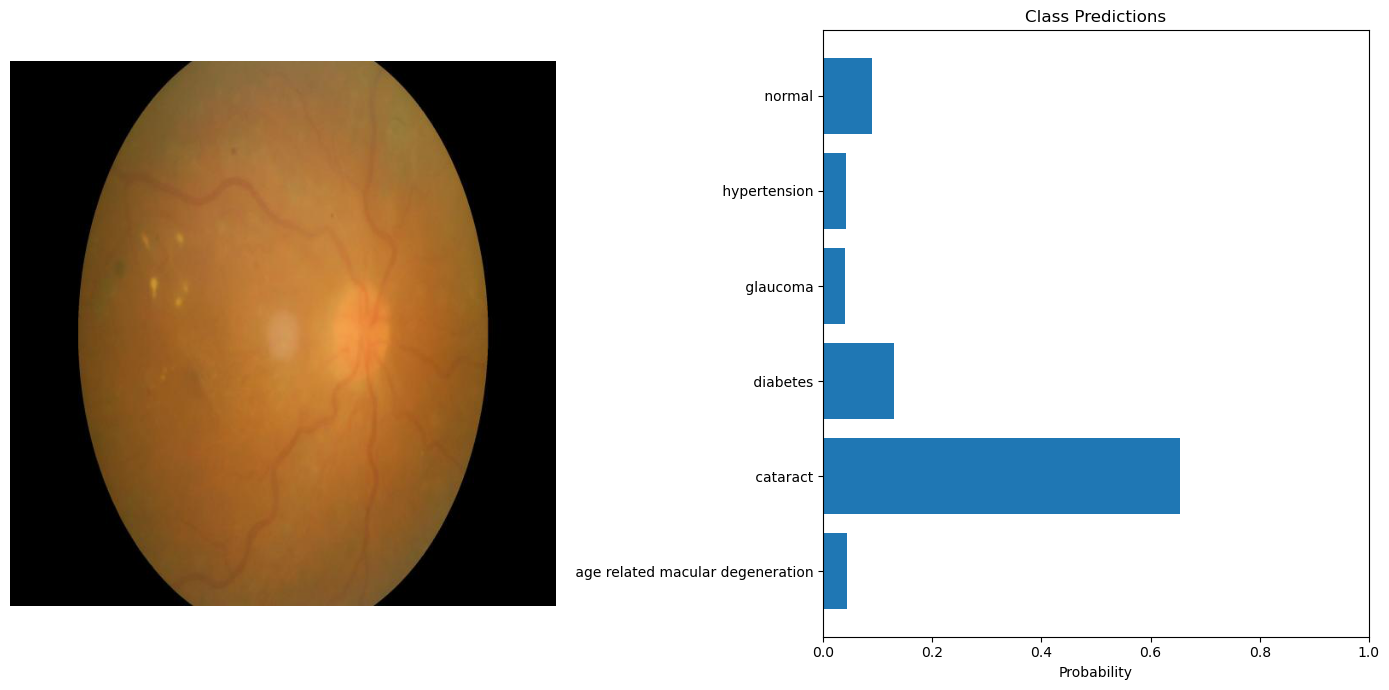

In [39]:
loaded_model = joblib.load('Image_Classification_Model.pkl')

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = loaded_model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "C:\\Users\\Muhammad.Taha2\\Documents\\University\\Deep Learning\\Assignment 2\\MSDSF22M020_Assignment_2\\Dataset\\Test\\ diabetes\\568_right_jpg.rf.d8ebf9d8c79d23c651f5182c902ec4e6.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)